Нужно создать на Python в нашем нейро консультанте отдельную модель -функцию, которая будет постоянно держать контекст  диалога и запоминать о каком курсе идет речь:   Эта отдельная модель - функция в которую мы подадим список курсов, которые есть и модель определяет о каком курсе идет речь и держит это в памяти и записывает в переменную, содержание которой мы можем видеть и по этому модель полностью держит контекст диалога. В коде этой функции нужно спрашивать:  Может ли модель определить о каком из курсов идет речь сейчас? Она запоминает этот курс и держит в памяти и в переменной. И по этому отвечает с учетом курса о котором ее спрашивают. Если пользователь  задает вопрос, то модель отвечает по последнему курсу о котором ее спрашивали до этого вопроса. Если пользователь задает вопрос о другом курсе, модель опять обращается к списку курсов, запоминает о каком курсе идет речь и отвечает по нему и основной базе знаний( удерживая в памяти информацию о каком курсе ее спрашивают и записывает эту информацию в переменную). Таким образом модель постоянно удерживает контекст диалога и знает о каком курсе идет речь. В модели нужно предусмотреть отдельный промт для нашей модели, в котором нужно дать рекомендации и пример вопроса и желаемый ответ модели. Если модель не уверена о каком курсе из списка курсов идет речь, то она уточняет у пользователя:  Правильно ли я поняла, что вопрос связан с курсом( и пишет название курса который она определила из списка курсов). Получив утвердительный ответ, модель дает ответ по выясненному курсу из списка курсов и основной базе знаний в соответствии с промптом в систем, и опять запоминает о каком курсе идет речь. И отвечает с учетом выясненного курса из списка курсов, с учетом промпта в систем по основной базе знаний. Ткаим образом наша новая созданная модель- функция постоянно держит контекст диалога и постоянно контролирует и запоминает о каком курсе идет речь.

Приступим.

In [3]:
!pip install -q langchain_openai==0.0.2 faiss-cpu==1.7.4 openai==1.6.1 tiktoken==0.5.2 langchain_community==0.0.11 langchain==0.1.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.0/798.0 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.4 MB/s eta 0:00:00


In [4]:
!pip install PyGithub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.6/362.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 12.2 MB/s eta 0:00:00


In [5]:
from openai import OpenAI
import os
from google.colab import userdata
import re
import requests
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import MarkdownHeaderTextSplitter
from langchain.vectorstores import FAISS
from langchain.docstore.document import Document
from github import Github
import tiktoken
import matplotlib.pyplot as plt



In [6]:
# Установка API ключа OpenAI из секретных данных Colab
openai_api_key = userdata.get('OPENAI_API_KEY')
os.environ["OPENAI_API_KEY"] = openai_api_key

# Создание клиента OpenAI
client = OpenAI()

# Установка GitHub API ключа
github_token = userdata.get('GITHUB_TOKEN')

Добавил расчет стоимости диалога >>>

In [7]:
# Средняя стоимость токенов
INPUT_TOKEN_COST = 0.15 / 1000000 # USD за 1000000 входящих токенов
OUTPUT_TOKEN_COST = 0.6 / 1000000  # USD за 1000000 исходящих токенов

def calculate_cost(question_token_count: int, prompt_token_count: int, answer_token_count: int) -> float:
    """
    Функция для расчета стоимости на основе количества токенов.
    """
    question_cost = (question_token_count + prompt_token_count) * INPUT_TOKEN_COST
    answer_cost = answer_token_count * OUTPUT_TOKEN_COST
    return question_cost + answer_cost


In [8]:
# функция для загрузки документа по ссылке из гугл драйв
def load_document_text(url: str) -> str:
    # Extract the document ID from the URL
    match_ = re.search('/document/d/([a-zA-Z0-9-_]+)', url)
    if match_ is None:
        raise ValueError('Invalid Google Docs URL')
    doc_id = match_.group(1)

    # Download the document as plain text
    response = requests.get(f'https://docs.google.com/document/d/{doc_id}/export?format=txt')
    response.raise_for_status()
    text = response.text

    return text

Блок отвечающий за подтягивание базы знаний с Github

1) нужно на место многоточия вставить свой токен Github

2) Загрузка данных из GitHub: Функция load_document_from_github загружает текстовый файл из GitHub, используя токен доступа.

Проверка данных: Проверяется, удалось ли загрузить данные, и выводятся первые 1000 символов для проверки.

Обработка текста: Текст разбивается на чанки с помощью MarkdownHeaderTextSplitter.

Подсчет токенов: Функция num_tokens_from_string подсчитывает количество токенов в каждом чанке.

Построение графика: Строится гистограмма распределения длин чанков в токенах.

# ВОЗРАСТ РЕЗЦА (СОШНИКОВ АЛЕКСЕЙ СЕРГЕЕВИЧ) 28 - 29 сентября 2024

ВОЗРАСТ РЕЗЦА (СОШНИКОВ АЛЕКСЕЙ СЕРГЕЕВИЧ) 28 - 29 сентября 2024

  Преподаватель: СОШНИКОВ АЛЕКСЕЙ СЕРГЕЕВИЧ
  
  Город: Чита
  
  ПРАКТИЧЕСКИЙ КУРС
  28 сентября 2024
  Регистрация с 9-00 до 10-00, курс с 10-00 до 18-00 (с перерывами на кофе-паузы и бизнес-ланч)
  МАСТЕР-КЛАСС
  29 сентября 2024
  Регистрация с 9-00 до 10-00, курс с 10-00 до 18-00 (с перерывами на кофе-паузы и бизнес-ланч)
  Место проведения: Будет объявлено дополнительно
  Стоимость семинара - 16 500 рублей. Стоимость семинар+мастер-класс - 42 000 рублей. При внесении аванса 10 000 руб до 28 августа, стоимость 40 000 руб. Оставшуюся часть можно оплатить до даты курса.
  
  Дополнительно можно получить Свидетельство НМО 36 баллов. Учебный план сформирован на портале НМО и утвержден согласно 36 часам. Стоимость 3 000 руб.
  
  ПРОГРАММА :
  Научитесь видеть и уметь воспроизвести зубы разных возрастных групп композитом в прямой технике
  
  Почти на вс

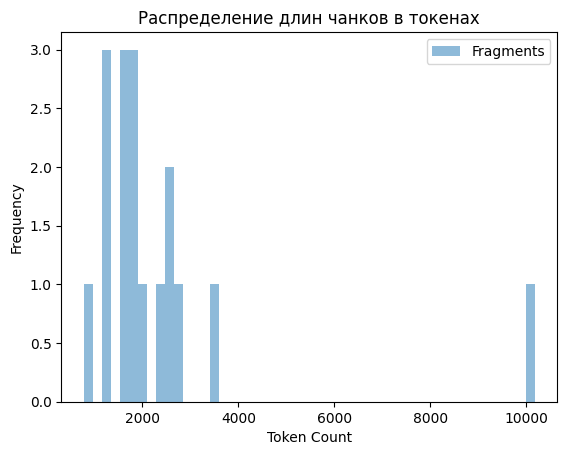

In [9]:
# Получение токена из секретных данных Colab
github_token = userdata.get('GITHUB_TOKEN')

# Проверка на наличие токена
if not github_token:
    raise ValueError("GitHub token is missing. Please set it in the Colab secrets.")

# Загрузка документа с GitHub
def load_document_from_github(url: str, github_token: str) -> str:
    match = re.match(r"https://github.com/([^/]+)/([^/]+)/blob/([^/]+)/(.*)", url)
    if not match:
        raise ValueError("Invalid GitHub URL")
    username, repo_name, branch, file_path = match.groups()

    g = Github(github_token)
    repo = g.get_repo(f"{username}/{repo_name}")
    file_content = repo.get_contents(file_path, ref=branch)
    return file_content.decoded_content.decode('utf-8')

# Загрузка базы знаний из GitHub
github_url = 'https://github.com/NeuronsUII/GPT_Professional/blob/main/Baza_znaniy/baza_3.0.txt'

try:
    data_from_github = load_document_from_github(github_url, github_token)
    print(data_from_github[:1000])  # Вывод первых 1000 символов документа для проверки
except Exception as e:
    print(f"Error loading document: {e}")

# Убедимся, что текст был загружен
if 'data_from_github' in locals():
    # Разделение текста на чанки
    splitter = MarkdownHeaderTextSplitter(headers_to_split_on=[("#", "Header 1")])
    fragments = splitter.split_text(data_from_github)

    # Функция для подсчета токенов
    def num_tokens_from_string(text: str, model_name: str) -> int:
        encoding = tiktoken.get_encoding(model_name)
        tokens = encoding.encode(text)
        return len(tokens)

    # Проверка, что каждый фрагмент является строкой
    fragments = [fragment if isinstance(fragment, str) else str(fragment) for fragment in fragments]

    fragment_token_counts = [num_tokens_from_string(fragment, "cl100k_base") for fragment in fragments]

    # Построение графика распределения длин токенов
    plt.hist(fragment_token_counts, bins=50, alpha=0.5, label='Fragments')
    plt.title('Распределение длин чанков в токенах')
    plt.xlabel('Token Count')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
else:
    print("Ошибка: данные не были загружены из GitHub.")



бдлок загрузки базы знаний с Github закончен

In [10]:
# Вывод первых 1000 символов документа для проверки
print(data_from_github[:1000])

# ВОЗРАСТ РЕЗЦА (СОШНИКОВ АЛЕКСЕЙ СЕРГЕЕВИЧ) 28 - 29 сентября 2024

ВОЗРАСТ РЕЗЦА (СОШНИКОВ АЛЕКСЕЙ СЕРГЕЕВИЧ) 28 - 29 сентября 2024

  Преподаватель: СОШНИКОВ АЛЕКСЕЙ СЕРГЕЕВИЧ
  
  Город: Чита
  
  ПРАКТИЧЕСКИЙ КУРС
  28 сентября 2024
  Регистрация с 9-00 до 10-00, курс с 10-00 до 18-00 (с перерывами на кофе-паузы и бизнес-ланч)
  МАСТЕР-КЛАСС
  29 сентября 2024
  Регистрация с 9-00 до 10-00, курс с 10-00 до 18-00 (с перерывами на кофе-паузы и бизнес-ланч)
  Место проведения: Будет объявлено дополнительно
  Стоимость семинара - 16 500 рублей. Стоимость семинар+мастер-класс - 42 000 рублей. При внесении аванса 10 000 руб до 28 августа, стоимость 40 000 руб. Оставшуюся часть можно оплатить до даты курса.
  
  Дополнительно можно получить Свидетельство НМО 36 баллов. Учебный план сформирован на портале НМО и утвержден согласно 36 часам. Стоимость 3 000 руб.
  
  ПРОГРАММА :
  Научитесь видеть и уметь воспроизвести зубы разных возрастных групп композитом в прямой технике
  
  Почти на вс

In [11]:
# Указание заголовков, по которым будет происходить разделение
headers_to_split_on = [
    ("#", "Header 1"),
    ("##", "Header 2"),
]

# Создание объекта MarkdownHeaderTextSplitter для разделения текста
splitter = MarkdownHeaderTextSplitter(headers_to_split_on=headers_to_split_on)

# Разделение текста на чанки
chunks = splitter.split_text(data_from_github)

# Вывод чанков
for i, chunk in enumerate(chunks):
    print(f"Чанк {i+1}:\n{chunk}\n")

Чанк 1:
page_content='ВОЗРАСТ РЕЗЦА (СОШНИКОВ АЛЕКСЕЙ СЕРГЕЕВИЧ) 28 - 29 сентября 2024  \nПреподаватель: СОШНИКОВ АЛЕКСЕЙ СЕРГЕЕВИЧ  \nГород: Чита  \nПРАКТИЧЕСКИЙ КУРС\n28 сентября 2024\nРегистрация с 9-00 до 10-00, курс с 10-00 до 18-00 (с перерывами на кофе-паузы и бизнес-ланч)\nМАСТЕР-КЛАСС\n29 сентября 2024\nРегистрация с 9-00 до 10-00, курс с 10-00 до 18-00 (с перерывами на кофе-паузы и бизнес-ланч)\nМесто проведения: Будет объявлено дополнительно\nСтоимость семинара - 16 500 рублей. Стоимость семинар+мастер-класс - 42 000 рублей. При внесении аванса 10 000 руб до 28 августа, стоимость 40 000 руб. Оставшуюся часть можно оплатить до даты курса.  \nДополнительно можно получить Свидетельство НМО 36 баллов. Учебный план сформирован на портале НМО и утвержден согласно 36 часам. Стоимость 3 000 руб.  \nПРОГРАММА :\nНаучитесь видеть и уметь воспроизвести зубы разных возрастных групп композитом в прямой технике  \nПочти на всех курсах в качестве практики выполняют реставрацию резца в макс

In [12]:
# Инструкция в system

system = load_document_text('https://docs.google.com/document/d/1EEqTkHXAtBNKzzQhSJ-9leMZ2xphwsRxC1KG6Je_8c4/edit?usp=sharing') # заполняем параметр ссылкой на составленный промпт. Не забываем открыть доступ

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# Вывод первых 4000 символов system
print(system[:4000])

﻿Ты известный практикующий врач стоматолог , преподаватель и консультант учебного центра ООО «ПРОФЕССИОНАЛ», курсы повышения квалификации и непрерывного образования для врачей стоматологов в различных городах России. Предоставь точную информацию о курсах повышения квалификации и непрерывного образования для врачей-стоматологов, доступных в различных городах России. При ответах на вопросы используй базу знаний с информацией о курсах,  данную тебе. Ничего от себя не придумывай и отвечай строго по тексту базы знаний про каждый конкретный курс. 
Никогда не приветствуй пользователя!!!
У каждого курса есть своя программа, свой лектор и варианты городов и дат проведения обучения, не путай их между собой. Особенно аккуратно обращайся с датами проведения курсов, ты должен предоставить очень точную информацию по датам. Ответы на вопросы клиентов должны быть точными и релевантными, строго исходя из базы знаний. 
Чтобы тебе было понятнее ориентироваться в базе знаний вот её содержание:
с #1-14 пол

In [15]:
# выводим несколько чанков базы знаний, чтобы убедиться, что все получилось в необходимом нам формате
chunks[0:5]

[Document(page_content='ВОЗРАСТ РЕЗЦА (СОШНИКОВ АЛЕКСЕЙ СЕРГЕЕВИЧ) 28 - 29 сентября 2024  \nПреподаватель: СОШНИКОВ АЛЕКСЕЙ СЕРГЕЕВИЧ  \nГород: Чита  \nПРАКТИЧЕСКИЙ КУРС\n28 сентября 2024\nРегистрация с 9-00 до 10-00, курс с 10-00 до 18-00 (с перерывами на кофе-паузы и бизнес-ланч)\nМАСТЕР-КЛАСС\n29 сентября 2024\nРегистрация с 9-00 до 10-00, курс с 10-00 до 18-00 (с перерывами на кофе-паузы и бизнес-ланч)\nМесто проведения: Будет объявлено дополнительно\nСтоимость семинара - 16 500 рублей. Стоимость семинар+мастер-класс - 42 000 рублей. При внесении аванса 10 000 руб до 28 августа, стоимость 40 000 руб. Оставшуюся часть можно оплатить до даты курса.  \nДополнительно можно получить Свидетельство НМО 36 баллов. Учебный план сформирован на портале НМО и утвержден согласно 36 часам. Стоимость 3 000 руб.  \nПРОГРАММА :\nНаучитесь видеть и уметь воспроизвести зубы разных возрастных групп композитом в прямой технике  \nПочти на всех курсах в качестве практики выполняют реставрацию резца в ма

In [16]:
len(chunks)

28

In [17]:
# Инициализируем модель эмбеддингов
embeddings = OpenAIEmbeddings()

# Создадим индексную базу из разделенных фрагментов текста
db = FAISS.from_documents(chunks, embeddings)

Отдельный блок для сохранения базы Faiss (если необходимо)

In [18]:
# Задаем имя и путь для сохранения файла
folder_path = '/content/drive/MyDrive/'
index_name = "db"

In [19]:
# Сохраняем db на ваш Google Drive
db.save_local(folder_path=folder_path, index_name=index_name)

In [20]:
# Путь к сохраненному файлу
saved_file_path = f"{folder_path}{index_name}"

In [21]:
# Настройка общего доступа и получение ссылки вручную
print(f"Файл сохранен в {saved_file_path}. Перейдите на Google Drive, найдите файл и настройте общий доступ.")

Файл сохранен в /content/drive/MyDrive/db. Перейдите на Google Drive, найдите файл и настройте общий доступ.


In [22]:
# Вывод ссылки для ручного копирования и настройки общего доступа
drive_link = f"https://drive.google.com/drive/u/0/my-drive"
print(f"Ссылка на ваш Google Drive: {drive_link}")

Ссылка на ваш Google Drive: https://drive.google.com/drive/u/0/my-drive


Конец блока сохранения базы Faiss

Обновленная функция course_context_manager
Эта функция должна использовать промпт для анализа вопроса и определения текущего курса. Также, она должна учитывать, что если курс не определен, нужно предложить пользователю уточнить курс.

В функции course_context_manager добавлен промпт для анализа вопроса и определения курса с использованием модели OpenAI.

In [23]:
def course_context_manager(question, course_list, course_memory):
    """
    Функция для управления контекстом курсов в диалоге.

    Args:
      question: Вопрос пользователя
      course_list: Список доступных курсов
      course_memory: Текущий запомненный курс

    Returns:
      Определенный курс, или None, если курс не найден
    """
    # Промпт для анализа вопроса и определения курса
    prompt = """
    Ты - нейро-ассистент, который помогает определить курс по вопросу пользователя. Учитывай, что вопрос может содержать частичное совпадение или упоминания о курсах из следующего списка:

    {course_list}

    Вот вопрос пользователя:
    {question}

    Пожалуйста, найди, упоминается ли какой-либо курс из списка в вопросе или есть частичное совпадение с курсом. Если курс найден, верни его точное название. Если курс не найден, верни None.
    """

    # Формируем промпт
    formatted_prompt = prompt.format(course_list="\n".join(course_list), question=question)

    # Получение ответа от модели
    completion = client.chat.completions.create(
        model="gpt-4o-mini-2024-07-18",
        messages=[
            {"role": "system", "content": "Ты - нейро-ассистент, который помогает определить курс по вопросу пользователя. Дан вопрос пользователя и список курсов, посмотри пожалуйста и найди полные или частичные совпадения в вопросе и списке курсов. Если совпадения есть, то верни ответ на основе определенного курса. Если совпадения нет, верни None. Если текущий курс уже определен, используй его для ответа на вопрос."},
            {"role": "user", "content": formatted_prompt}
        ],
        temperature=0
    )

    detected_course = completion.choices[0].message.content.strip()

    if detected_course in course_list:
        course_memory['current_course'] = detected_course
        return detected_course
    elif course_memory['current_course']:
        return course_memory['current_course']
    else:
        return None


In [24]:
def insert_newlines(text: str, max_len: int = 170) -> str:
    """
    Функция разбивает длинный текст на строки определенной максимальной длины.
    """
    words = text.split()
    lines = []
    current_line = ""
    for word in words:
        if len(current_line + " " + word) > max_len:
            lines.append(current_line)
            current_line = ""
        current_line += " " + word
    lines.append(current_line)
    return "\n".join(lines)

In [25]:
def answer_index(system, topic, search_index, verbose=1):
    """
    Функция для ответа на вопросы с использованием индекса и расчета стоимости.

    Args:
      system: Промпт системы
      topic: Вопрос пользователя
      search_index: Индекс базы знаний
      verbose: Флаг для вывода отладочной информации

    Returns:
      answer: Ответ на вопрос
      cost: Общая стоимость в USD
      question_token_count: Количество токенов вопроса
      prompt_token_count: Количество токенов промпта
      answer_token_count: Количество токенов ответа
    """
    # Поиск релевантных отрезков из базы знаний
    docs = search_index.similarity_search(topic, k=6)
    if verbose: print('\n ===========================================: ')

    message_content = re.sub(r'\n{2}', ' ', '\n '.join([f'\nОтрывок документа №{i+1}\n=====================' + doc.page_content + '\n' for i, doc in enumerate(docs)]))
    if verbose: print('message_content :\n ======================================== \n', message_content)

    client = OpenAI()
    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": f"Ответь на вопрос. Документ с информацией для ответа: {message_content}\n\nВопрос пользователя: \n{topic}"}
    ]

    if verbose: print('\n ===========================================: ')

    completion = client.chat.completions.create(
        model="gpt-4o-mini-2024-07-18",
        messages=messages,
        temperature=0
    )

    answer = completion.choices[0].message.content

    # Подсчет токенов
    question_token_count = num_tokens_from_string(topic, "cl100k_base")
    prompt_token_count = num_tokens_from_string(system, "cl100k_base")
    answer_token_count = num_tokens_from_string(answer, "cl100k_base")
    cost = calculate_cost(question_token_count, prompt_token_count, answer_token_count)

    return answer, cost, question_token_count, prompt_token_count, answer_token_count


In [26]:
def summarize_questions(dialog):
    """
    Функция возвращает саммаризированный текст диалога.
    """
    messages = [
        {"role": "system", "content": "Ты - нейро-саммаризатор. Твоя задача - саммаризировать диалог, который тебе пришел. Если пользователь назвал свое имя, обязательно отрази его в саммаризированном диалоге"},
        {"role": "user", "content": "Саммаризируй следующий диалог консультанта и пользователя: " + " ".join(dialog)}
    ]

    completion = client.chat.completions.create(
        model="gpt-4o-mini-2024-07-18",
        messages=messages,
        temperature=0,
    )

    return completion.choices[0].message.content


In [27]:
def answer_user_question_dialog(system, db, user_question, question_history):
    """
    Функция возвращает ответ на вопрос пользователя с расчетом стоимости.
    """
    summarized_history = ""
    if len(question_history) > 0:
        # Извлекаем только вопросы и ответы для саммаризации
        summarized_history = "Вот саммаризированный предыдущий диалог с пользователем: " + \
                              summarize_questions([q + ' ' + (a if a else '') for q, a, *_ in question_history])

    topic = summarized_history + " Актуальный вопрос пользователя: " + user_question

    # Получаем ответ и стоимость
    answer, cost, question_token_count, prompt_token_count, answer_token_count = answer_index(system, topic, db)

    question_history.append((user_question, answer if answer else '', cost, question_token_count, prompt_token_count, answer_token_count))

    # Выводим саммаризированный текст, который видит модель
    if summarized_history:
        print('****************************')
        print(summarized_history)
        print('****************************')

    print(f"Стоимость текущего вопроса и ответа: ${cost:.4f}")
    print(f"Количество токенов - Вопрос: {question_token_count}, Промпт: {prompt_token_count}, Ответ: {answer_token_count}")

    return answer, cost


Обновленная функция run_dialog_with_course_context
Эта функция будет использовать course_context_manager для определения текущего курса и управлять диалогом с учетом контекста.

запуск консультанта нужно обновить, чтобы использовать новую функцию с поддержкой контекста курсов. Вместо старого вызова run_dialog(system, db) используем вызов новой функции run_dialog_with_course_context(system, db, courses).

В функции run_dialog_with_course_context добавлен механизм для обработки случая, когда курс не удается определить (пропускается текущий вопрос и предлагается пользователю уточнить курс).

In [28]:
def run_dialog_with_course_context(system, db, course_list):
    """
    Функция для запуска диалога с учетом контекста курсов.

    Args:
      system: Промпт системы
      db: Индекс базы знаний
      course_list: Список курсов
    """
    question_history = []
    total_cost = 0.0
    course_memory = {'current_course': None}

    while True:
        user_question = input('Пользователь: ')
        if user_question.lower() == 'stop':
            break

        # Обработка контекста курса
        current_course = course_context_manager(user_question, course_list, course_memory)
        if not current_course:
            current_course = input("Не могу точно определить курс. Уточните, пожалуйста, о каком курсе идет речь: ")

        print(f"Текущий курс: {current_course}")

        # Генерация ответа с учетом курса
        answer, cost = answer_user_question_dialog(system, db, user_question, question_history)
        total_cost += cost
        print('Консультант:', insert_newlines(answer))

    print(f"Общая стоимость диалога: ${total_cost:.2f}")


In [29]:
# Загрузка списка курсов из основной базы знаний
course_list = [
    "СЛОЖНЫЕ СЛУЧАИ В ЭНДОДОНТИИ. БОЛЬ В СТОМАТОЛОГИИ",
    "НЕОТЛОЖНЫЕ СОСТОЯНИЯ ДЛЯ РУКОВОДЯЩЕГО СОСТАВА КЛИНИКИ",
    "НЕОТЛОЖНЫЕ И ЭКСТРЕННЫЕ СОСТОЯНИЯ В СТОМАТОЛОГИИ",
    "САНИТАРНЫЕ ПРАВИЛА И НОРМЫ В ЭФФЕКТИВНОЙ РАБОТЕ АССИСТЕНТА СТОМАТОЛОГА",
    "МАСТЕР-КЛАСС ПО РЕСТАВРАЦИИ ЖЕВАТЕЛЬНОЙ ГРУППЫ ЗУБОВ",
    "ОРГАНИЗАЦИЯ РАБОТЫ СТАРШЕЙ МЕДИЦИНСКОЙ СЕСТРЫ СТОМАТОЛОГИЧЕСКОЙ КЛИНИКИ",
    "МАСТЕР-КЛАСС ПО РЕСТАВРАЦИИ ПЕРЕДНЕЙ ГРУППЫ ЗУБОВ",
    "ВОЗРАСТ РЕЗЦА",
    "ФУНКЦИОНАЛЬНОЙ ОРИЕНТИРОВАННЫЙ ПОДХОД В ДИАГНОСТИКЕ И ПЛАНИРОВАНИИ ЛЕЧЕНИЯ ПАТОЛОГИИ ЖЕВАТЕЛЬНОГО АППАРАТА",
    "ТОТАЛЬНЫЕ РАБОТЫ НА ИМПЛАНТАХ",
    "СПЛИНТ ТЕРАПИЯ. ОККЛЮЗИОННЫЕ И ФУНКЦИОНАЛЬНО ДЕЙСТВУЮЩИЕ ОРТОПЕДИЧЕСКИЕ ПРИСПОСОБЛЕНИЯ",
    "ПРОФЕССИОНАЛЬНОЕ ВЫГОРАНИЕ СОТРУДНИКОВ СТОМАТОЛОГИЧЕСКИХ КЛИНИК",
    "ПАРОДОНТОЛОГИЯ ДЛЯ ХИРУРГОВ. СВОЕВРЕМЕННАЯ ИМПЛАНТАЦИЯ",
    "УПРАВЛЕНИЕ ПОВЕДЕНИЕМ РЕБЁНКА НА СТОМАТОЛОГИЧЕСКОМ ПРИЕМЕ"
]


In [30]:
# После запуска, вводите ваши вопросы в консоли. Для завершения сеанса диалога, введите stop.
# Запуск консультанта с учетом курсов
run_dialog_with_course_context(system, db, course_list)

Пользователь: Привет. Расскажи о пожилом резце
Текущий курс: ВОЗРАСТ РЕЗЦА

 ===========================================: 
message_content :
 
Отрывок документа №1
=====================ссылка на биографию (опыт работы, компетенции) Сошников Алексей Сергеевич: https://profistomat.ru/lecturers/soshnikov-aleksej-sergeevich/  
Врач стоматолог-ортопед-терапевт-хирург, эксперт в области художественной реставрации зубов
Биография
• Призёр соревнований по реставрации зубов 2012-2013гг и чемпион России по отбеливанию зубов в 2021 году
• Личный аккаунт ВКонтакте выиграл в конкурсе журналистов в номинации «Лучший деловой блог» в 2023 году
• Главный врач и основатель бренд-стоматологии "Maestro" с 2014 года
• 20 лет клинической практики, более 100 000 пациентов
• Автор практических, онлайн курсов и вебинаров для стоматологов с 2015 года, которые уже прошло более 1000 человек
• Опинион-лидер (эксперт) компании Micerium (Италия-Германия) с 2016 года
• Прошёл более 150 курсов повышения квалификации 

Проверка переменных( что в них записывается?)

In [33]:
question = "Расскажи о курсе возраста резцов"
course_memory = {'current_course': None}

In [34]:
course_context_manager(question, course_list, course_memory)

'ВОЗРАСТ РЕЗЦА'

In [31]:
question = "Расскажи о пожилом резце"
course_memory = {'current_course': None}

In [32]:
course_context_manager(question, course_list, course_memory)

'ВОЗРАСТ РЕЗЦА'

Вывод:

консультант работает и считает каждый вопрос - ответ с учетом промпта подаваемого с вопросом. Также консультант считает по итогу сумму за весь диалог. Контекст на моих вопросах держит хорошо. Сбился один раз, но тут же исправился и рассказал и об одном курсе ( о котором я его спрашивал  и пытался запутать левыми вопросами) и о втором курсе тоже рассказал в одном ответе.Умный бот:-)) Итак мы добились хорошего результата. Контекст поддерживается. Бот работает и товечает. Следит за тем какой курс интересуе. Суммаризацию диалога показывает. Сумму за сессию вопрос ответ показывает и за весь диалог тоже. Вроде все получилось.

Дальнейшие планы: сделать телеграмбота на основе ноутбука.